In [1]:
#https://www.gymlibrary.dev/content/environment_creation/
import gym
import gym_examples

import math
import random
import time
import gc

import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display as ipd
from collections import deque

# Import Tensorflow 2.0
import tensorflow as tf
from livelossplot import PlotLosses

from time import sleep
from tqdm import tqdm



#env = gym.make('gym_examples/GridWorld-v0', render_mode='human')
#env = gym.make('gym_examples/PuckWorld-v0', render_mode='human')
#env = gym.make('MountainCar-v0', render_mode='human')
#env = gym.make('CartPole-v1', render_mode='human')
         


In [2]:
#def create_rl_model(n_actions):
    
#    model = tf.keras.models.Sequential([
#        tf.keras.layers.Dense(units=32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)),
#        tf.keras.layers.Dense(units=32, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)),
#        tf.keras.layers.Dense(units=n_actions, activation=None, kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01))  #returns logits (un-normalized log-proba for each action)
#    ])
#    return model

class DQN(tf.keras.Model):
    """Dense neural network class."""
    def __init__(self, num_actions):
        super(DQN, self).__init__()
        
        kernel_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05)
        bias_initializer = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05)
        
        self.dense1 = tf.keras.layers.Dense(100, activation="relu", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dense2 = tf.keras.layers.Dense(100, activation="relu", kernel_initializer=kernel_initializer, bias_initializer=bias_initializer)
        self.dense3 = tf.keras.layers.Dense(num_actions, dtype=tf.float32, kernel_initializer=kernel_initializer) # No activation
    
    def call(self, x):
        """Forward pass."""
        x = self.dense1(x)
        x = self.dense2(x)
        return self.dense3(x)

#a logbook to remember observations, actions and rewards for an entire episode
class Memory:
    def __init__(self, length=0, batch_size=0):
        self.length = length
        self.batch_size = batch_size
        self.clear()
    
    def clear(self):
        self.observations=[]
        self.actions=[]
        self.rewards=[]
        self.dones=[]
        self.next_obs=[]
        
    def add_to_memory(self, obs, action, reward, done, next_obs):
        self.observations.append(obs)
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        self.next_obs.append(next_obs)
        
        if self.length>0 and len(self.actions)>self.length:
            self.observations.pop(0)
            self.actions.pop(0)
            self.rewards.pop(0)
            self.dones.pop(0)
            self.next_obs.pop(0)
    
    def sample(self):
        if self.batch_size>0:
            i = np.random.randint(0, len(self.actions), self.batch_size) #select a random batch from memory
            o = [self.observations[j] for j in i]
            a = [self.actions[j] for j in i]
            r = [self.rewards[j] for j in i]
            d = [self.dones[j] for j in i]
            no = [self.next_obs[j] for j in i]
            return o,a,r,d,no
        else:
            return self.observations, self.actions, self.rewards, self.dones, self.next_obs
        
    def __len__(self):
        return len(self.actions)

def choose_action(model, observation, num_actions, greedy=True, epsilon=0.):

    if random.uniform(0,1)<epsilon:
        opt = np.random.randint(0, high=num_actions)
        return opt
    else:
        observation_a = tf.expand_dims(observation, axis=0) #assume a single obs is passed, the model expects an array of inputs
        logits = model(observation_a)
        opt = tf.argmax(logits, axis=-1)
        return opt[0].numpy() 







In [3]:
@tf.function
def train_step(target_model, model, observations, actions, rewards, next_observations, dones, gamma):
    
    targets = rewards + gamma * tf.reduce_max( target_model(next_observations), axis=1 )

    with tf.GradientTape() as tape:

        #calculate the Q values; model return the Q values for all possible actions
        #the model returns the Q values of all the actions for each observation
        Q = model(observations)  

        #keep only the Q value of the action that was actually taken
        #idea to use one_hot from https://markelsanz14.medium.com/introduction-to-reinforcement-learning-part-3-q-learning-with-neural-networks-algorithm-dqn-1e22ee928ecd
        mask = tf.one_hot(actions, num_actions) 
        q = tf.math.reduce_sum(mask * Q, axis=1)

        #batch loss is average mean square error
        loss = tf.keras.metrics.mean_squared_error(targets, q)

    grads = tape.gradient(loss, model.trainable_variables)
    #grads, _ = tf.clip_by_global_norm(grads, 2.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [4]:
@tf.function
def train_step_clamp(target_model, model, observations, actions, rewards, next_observations, dones, gamma=0.99, td_error_clamp=0):
    
    targets = rewards + gamma * tf.reduce_max( target_model(next_observations), axis=1 )

    with tf.GradientTape() as tape:

        #calculate the Q values; model return the Q values for all possible actions
        #the model returns the Q values of all the actions for each observation
        Q = model(observations)  

        #keep only the Q value of the action that was actually taken
        #idea to use one_hot from https://markelsanz14.medium.com/introduction-to-reinforcement-learning-part-3-q-learning-with-neural-networks-algorithm-dqn-1e22ee928ecd
        mask = tf.one_hot(actions, num_actions) 
        q = tf.math.reduce_sum(mask * Q, axis=1)

        td_err = tf.math.squared_difference(targets,q)
        if td_error_clamp>0:
            td_err = tf.where(tf.math.greater(td_err,td_error_clamp), td_error_clamp, td_err)
        
        #batch loss is average mean square error
        loss = tf.math.reduce_mean(td_err) #tf.keras.metrics.mean_squared_error(targets, q)

    grads = tape.gradient(loss, model.trainable_variables)
    #grads, _ = tf.clip_by_global_norm(grads, 2.0)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [5]:
memory_length = 100000
add_to_experience = 1 #add to experience every N steps
train_period = 1 #number of steps before model is trained
batch_size = 32 #number of steps sampled from experience when training the model

gamma = 0.99
greedy=True
epsilon=0.3
epsilon_halflife = 50
epsilon_min = 0.01
learning_rate = 0.0001
td_error_clamp = 1.

env = gym.make('gym_examples/PuckWorld-v0', reward1=True, reward2=True, render_mode=None, fps=0)  #'human'
#env = gym.make('CartPole-v1', render_mode=None)  #'human'
num_obs = env.observation_space.shape[0]
num_actions = env.action_space.n
#num_actions = 5 #PuckWorld: 0,1,2,3,4 represent left, right, up, down, -, five moves.

model = DQN(num_actions) #create_rl_model(num_actions)
#model.compile()

target_model = DQN(num_actions)
#target_model.compile()

memory = Memory(memory_length, batch_size)  

optimizer = tf.keras.optimizers.Adam(learning_rate)

plotlosses = PlotLosses()

t = 0
log = deque(maxlen=10)  #remember the last 10 episodes to smooth values
log2 = []

C:\Users\remyh\AppData\Roaming\Python\Python38\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [14]:
#env._max_episode_steps = 60*10  
max_episode_steps = 60*10  #10sec = 60fps*10''
obs, info = env.reset()
num_episodes = 10000 #

epsilon=0.5
epsilon_halflife = 500
epsilon_min = 0.1

tqdm_episodes = range(num_episodes) #tqdm(range(num_episodes))

truncated = False

for episode in tqdm_episodes:

    obs, info = env.reset()
    episode_score = 0

    #run an episode:
    start_t = t
    while t-start_t < max_episode_steps:

        #tqdm_episodes.set_postfix({'t': t})

        action = choose_action(model, obs, num_actions, greedy=greedy, epsilon=epsilon)
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        episode_score += reward
#        plotlosses.update({'reward': reward})

        if t % add_to_experience == 0:
            memory.add_to_memory(obs, action, reward, done, next_obs)

            
        if len(memory)>=batch_size and t % train_period == 0:

            o,a,r,d,no = memory.sample()

            observations=np.vstack(o)
            actions=np.array(a)
            rewards = np.array(r, dtype=np.float32)
            dones = np.array(d)
            next_observations=np.vstack(no)

            loss = train_step_clamp(target_model, model, observations, actions, rewards, next_observations, dones, gamma=gamma, td_error_clamp=td_error_clamp)

        if done:
            break #out of the episode

#            plotlosses.update({'loss': loss})

        env.render()
        obs = next_obs
        t += 1

    target_model.set_weights(model.get_weights())
    
    #plotlosses.update({'score': episode_score})
    log.append((epsilon, episode_score/(t-start_t)))

    if epsilon > epsilon_min:
        epsilon -= epsilon * math.log(2)/epsilon_halflife

    if episode % len(log) == 0:
        #plotlosses.send()  # draw, update logs, etc
        e_mean = np.mean([e for (e,s) in log])
        s_mean = np.mean([s for (e,s) in log])
        log2.append([e_mean, s_mean])
        print(f'Episode {episode}/{num_episodes}. Epsilon: {epsilon:.3f}. '
            f'Average score in last {len(log)} episodes: {s_mean:.3f}')

    gc.collect()
    
    if truncated:
        break #out of the main loop


env.close()    


Episode 0/10000. Epsilon: 0.499. Average score in last 10 episodes: -0.326
Episode 10/10000. Epsilon: 0.492. Average score in last 10 episodes: -0.338
Episode 20/10000. Epsilon: 0.486. Average score in last 10 episodes: -0.413
Episode 30/10000. Epsilon: 0.479. Average score in last 10 episodes: -0.381
Episode 40/10000. Epsilon: 0.472. Average score in last 10 episodes: -0.376
Episode 50/10000. Epsilon: 0.466. Average score in last 10 episodes: -0.386
Episode 60/10000. Epsilon: 0.459. Average score in last 10 episodes: -0.388
Episode 70/10000. Epsilon: 0.453. Average score in last 10 episodes: -0.358
Episode 80/10000. Epsilon: 0.447. Average score in last 10 episodes: -0.374
Episode 90/10000. Epsilon: 0.441. Average score in last 10 episodes: -0.390
Episode 100/10000. Epsilon: 0.435. Average score in last 10 episodes: -0.405
Episode 110/10000. Epsilon: 0.429. Average score in last 10 episodes: -0.338
Episode 120/10000. Epsilon: 0.423. Average score in last 10 episodes: -0.375
Episode 13

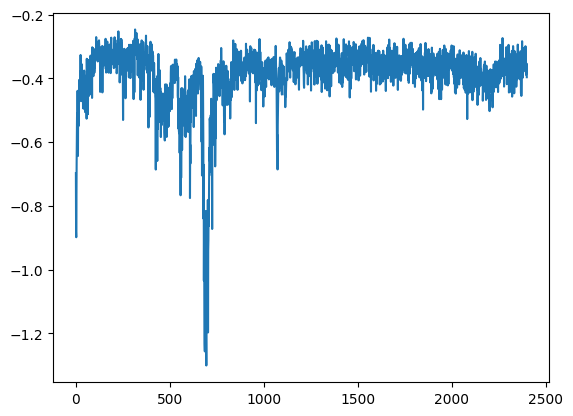

In [16]:
#plt.plot(np.array(log2)[:,0], np.array(log2)[:,1])
plt.plot(np.array(log2)[:,1])

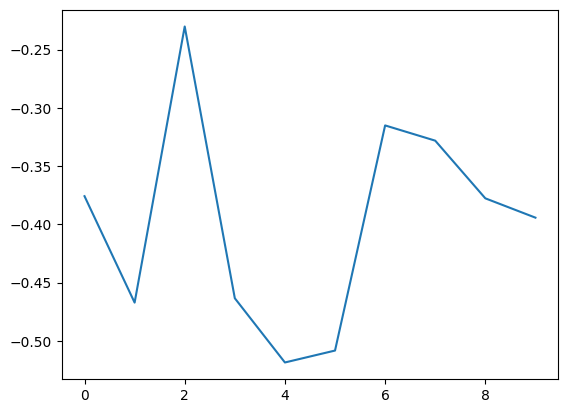

In [15]:
e = [e for (e,s) in log]
s = [s for (e,s) in log]
plt.plot(s)


In [17]:
# Uncomment following line to save video of our Agent interacting in this environment
# This can be used for debugging and studying how our agent is performing
# env = gym.wrappers.Monitor(env, './video/', force = True)
envh = gym.make('gym_examples/PuckWorld-v0', reward1=True, reward2=True, render_mode='human', fps=60)  #'human'

envh._max_episode_steps = 60*30
t = 0
observation, info = envh.reset()
episode_score=0
while True:
    envh.render()
    t += 1
    #action = env.action_space.sample()
    action = choose_action(model, observation, num_actions, greedy=True, epsilon=0.0)
    observation, reward, terminated, truncated, info = envh.step(action)
    episode_score += reward
    if terminated or truncated:
        observation, info = envh.reset()
        break
print("Episode finished after {} timesteps, score {}".format(t, episode_score/t))
envh.close()

Episode finished after 3331 timesteps, score -0.5256580404429925
